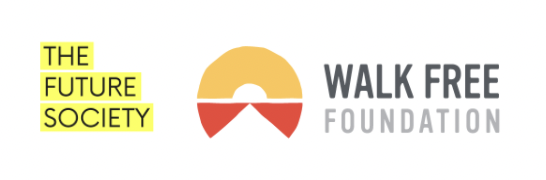

#*Project AIMS (AI against Modern Slavery)*
---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1t0v8BxLQuCmUkebMrnn9mLlpMe9CLqzj/view?usp=sharing).

 
# Risk assessment
## How does the company assess the risks of modern slavery and trafficking in their supply chain?
 
After eliciting their supply chain risks, an organisation must then evaluate the risk of modern slavery to make decisions to take specific actions against modern slavery. This assessment can be executed as part of an organisation’s wider approach to risk but should give specific information about modern slavery risk and also data related to the company’s size, structure, location of supply chains, and nature of business. This metric refers to the tools or mechanisms that companies use to assess risk.
 
This metric asks how a company assesses risks, not the identification of these risks. These risk assessment tools must be specific to modern slavery and go beyond general tools related to Corporate Social Responsibility (CSR).
This can include:
Requiring all new suppliers to complete risk-based questionnaires,
The use of a specified risk management database or tool, such as Maplecroft, or Sedex, or Researching to assess risk. This can include using existing research such as the Global Slavery Index, the Corruption Perception Index; Human Rights Watch reports, Amnesty International Reports or reports produced by the UN.
 
For more information about this metric, please refer to  [WikiRate’s Research on MSA risk assessment metric](https://wikirate.org/Walk_Free_Foundation+MSA_risk_assessment), or [ Home Office Guidance, pp. 34-35](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf).
 
## Labelled dataset
When building the ground truth data for this metric, if a company outlines in the statement that it requires suppliers to complete questions, the annotators give the statement the label 'risk-based questionnaires'. If a company describes a tool, such as a risk matrix, or the use of software such as Maplecroft or Sedex, the label given is 'use of risk management tool or software. If a company describes conducting its research into its supply chain, the label was 'conducting research. If a statement had any of those labels given for this task, it was revealed with ‘Yes/1’. For each value, the annotations included a Comment that copies relevant information and page numbers from the statement.
If the business indicates it is developing risk management tools specific to modern slavery or planning to implement one in the future, the label given by annotators was 'In Development'. Where there are no details of risk assessment strategies, the statement was labelled with 'No'. For this task, if a statement had any of those two labels, it was relabell
ed ‘No/0’.
 



In [ ]:
#!pip install unidecode
#!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import warnings
warnings.simplefilter('ignore')


### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).



In [ ]:
# Authenticate
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Extract document ID
file_path = 'https://drive.google.com/open?id=1yh_dBs51I825YnT_H7WMs8cPLeIUdUpJ'
fluff, id = file_path.split('=')
print(id)

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labeled-dataset.csv')
df3 = pd.read_csv('labeled-dataset.csv')

1yh_dBs51I825YnT_H7WMs8cPLeIUdUpJ


## Text preprocessing
Text preprocessing step includes:
- stemming
- lemmatisation
- stop words removal
- tokenization


In [ ]:
import os
import numpy as np
import re
import unidecode
from pathlib import Path
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize.punkt import PunktSentenceTokenizer

sentence_split = PunktSentenceTokenizer().tokenize

metrics = {
           "assessment"     : "Walk Free Foundation+MSA risk assessment",
           "identification" : "Walk Free Foundation+MSA Identification of risks",
           "management"     : "Walk Free Foundation+MSA risk management (revised)",
           }

true_values = {"assessment" : ["conducting research", 
                               "risk-based questionnaires",
                               "use of risk management tool or software"],
               "identification" : ["geographic", 
                                   "industry", 
                                   "resource", 
                                   "workforce",
                                   "yes"],
               "management" : ["audits of suppliers (independent)",
                               'audits of suppliers (self- reporting)',
                               'on-site visits (independent)',
                               'on-site visits (self- reporting)']
               }

class Preprocessing:
    def __init__(self):
        self.stem = SnowballStemmer('english').stem
        lemmer = WordNetLemmatizer()
        self.lem  = lambda text : lemmer.lemmatize(text, pos='v')
        self.stop_words = gensim.parsing.preprocessing.STOPWORDS
        self.prepreprocessing = gensim.utils.simple_preprocess
    
    def remove_accents(self, text):
        return unidecode.unidecode(text)
        
    def lem_stem(self, word):
        return self.stem(self.lem(word))

    def __call__(self, text):
        text = self.remove_accents(text)
        result = []
        for token in self.prepreprocessing(text):
            if token not in self.stop_words and len(token) > 3:
                result.append(self.lem_stem(token))
        return result
    
def doc_to_sentences(doc):
    doc = " ".join(doc.splitlines())
    return sentence_split(doc)

def compute_columns(df, metric):
    df = df.copy()
    metric_col = metrics[metric]
    df.dropna(subset=[metric_col], inplace=True)
    df[metric_col] = df[metric_col].str.lower().str.split(',')
    df[metric_col] = df[metric_col].apply(lambda x : [y.strip() for y in x])
    possible_values = np.unique(np.concatenate(df[metric_col].values))
    print('Possible values : {}'.format(possible_values))

    for v in possible_values:
        df['[{}] == {}'.format(metric, v)] = df[metric_col].apply(lambda x : v in x)

    for v in ['nan', 'unknown']:
        na_col_name = '[{}] == {}'.format(metric, v)
        if na_col_name in df.columns:
            df = df[~df[na_col_name]] #removing examples where it is unknown
            df.pop(na_col_name)
    df.pop(metric_col)
    return df

def binary_only(df, metric):
    df['Metric'] = False
    col_start = '[{}] == '.format(metric)
    for c in df.columns:
        if c.startswith(col_start):
            if c[len(col_start):] in true_values[metric]:
                df['Metric'] = df['Metric'] | df[c] #OR
            df.pop(c)
    
    return df

def load_dataset(metric='', data_folder='./drive/MyDrive/data/', binary=True):
    useful_cols = ['Answer Link', 'TEXT','Company']
    data_file    = os.path.join(data_folder,
                                "labeled-dataset.csv")
    df = pd.read_csv(data_file)
    df.dropna(subset=['TEXT'], inplace=True)
    
    if metric:
        df = df[useful_cols + [metrics[metric]]]
        df = compute_columns(df, metric)
        if binary:
            df = binary_only(df, metric)
    else:
        df = df[useful_cols]
        
    subset = [x for x in df.columns if not x in ['Answer Link', 'Company']]
    df = df.drop_duplicates(subset=subset)
    
    #now there should not be any duplicate on the text
    #if this is the case, that means we have same text and different metric, so we remove it
    counts = df['TEXT'].value_counts()
    to_be_removed = counts[counts > 1].index
    df = df[~df['TEXT'].isin(to_be_removed)]
    
    return df

def load_dataset_from_gdrive(metric='', doc_id='1yh_dBs51I825YnT_H7WMs8cPLeIUdUpJ', binary=True):
    useful_cols = ['Answer Link', 'TEXT','Company']

    downloaded = drive.CreateFile({'id': doc_id}) 
    downloaded.GetContentFile('labeled-dataset.csv')
    df = pd.read_csv('labeled-dataset.csv')

    df.dropna(subset=['TEXT'], inplace=True)
    
    if metric:
        df = df[useful_cols + [metrics[metric]]]
        df = compute_columns(df, metric)
        if binary:
            df = binary_only(df, metric)
    else:
        df = df[useful_cols]
        
    subset = [x for x in df.columns if not x in ['Answer Link', 'Company']]
    df = df.drop_duplicates(subset=subset)
    
    #now there should not be any duplicate on the text
    #if this is the case, that means we have same text and different metric, so we remove it
    counts = df['TEXT'].value_counts()
    to_be_removed = counts[counts > 1].index
    df = df[~df['TEXT'].isin(to_be_removed)]
    
    return df

def clean_comment(text):
    BAD_COMMENT_KEYWORDS = [
                            'i did not', 
                            'there is no', 
                            'they do not', 
                            'i could not', 
                            'it does not', 
                            "the company’s statement",
                            'wikirate',
                            'does not state',
                            'statement',
                            'not mentioned',
                            'no mention',
                            'i do not',
                            'not reported',
                            'no specific',
                            'the report'
                            ]
    
    text = text.lower().strip()
    
    #fixing not ending quotes
    for quote in ['"',"'"]:
        if text.count(quote) == 1 and text[0] == quote:
            text += quote
            break
    
    in_quotes = re.findall('"([^"]*)"', text) + re.findall("'([^']*)'", text)
    in_quotes = [x for x in in_quotes if len(x.strip()) > 0]
    
    if any(['wikirate' in x for x in in_quotes]):
        quote_indexes = np.array([text.find('"'), text.find("'")])
        quote_indexes = np.where(quote_indexes == -1 , len(text), quote_indexes)
        first_quote_i = np.argmin(quote_indexes)
        first_quote_type = ['"', "'"][first_quote_i]
        return clean_comment(text[quote_indexes[first_quote_i] + 1:] + first_quote_type)
    
    if len(in_quotes) > 0:
        split = in_quotes
    else:
        split = re.split('\[https://wikirate.org/[a-z0-9_]+\][0-9\-\. :]+utc', text)
        
    split = [x for x in split if len(x) > 0]
    split = [x for x in split if not any([kw in x for kw in BAD_COMMENT_KEYWORDS])]
    
    new_split = []
    for t in split:
        #removing bad endings when they are in the format '. [NAME]'
        dot_split = t.split('.')
        if len(dot_split) > 1 and len(dot_split[-1].strip().split()) < 4:
            t = '.'.join(dot_split[:-1]) + '.'
            
        new_split.append(t)
    return new_split

def alphanum(text):
    return re.sub('[^a-z0-9]', '', text.lower())
    
def _comment_is_in_text(row):
    row['COMMENTS'] = [x for x in row['COMMENTS'] if alphanum(x) in alphanum(row['TEXT'])]
    #removing stupid comments
    row['COMMENTS'] = [x for x in row['COMMENTS'] if len(alphanum(x)) > 0 and len(x.split()) > 2]
    
    return row

def load_comments(metric, data_folder='./drive/MyDrive/data/', to_dic=True):
    data_file = os.path.join(data_folder,
                             "modern-slavery-dataset-metrics.csv")

    df = pd.read_csv(data_file)[['TEXT', 'METRIC NAME', 'COMMENTS']]
    df.dropna(inplace=True)
    
    df = df[df['METRIC NAME'] == metrics[metric]]
    df['COMMENTS'] = df['COMMENTS'].apply(clean_comment)
    df = df.apply(_comment_is_in_text, axis=1) #adding only comments that we found in the text
    df.pop('METRIC NAME')
    
    if to_dic:
        #merging duplicate texts, removing lines where there is no comments
        comments = {}
        for i, row in df.iterrows():
            text = row['TEXT']
            if len(row['COMMENTS']) > 0:
                if not text in comments:
                    comments[text] = []
                comments[text] += row['COMMENTS']
                
        #using labelliser to find the comments inside the text
        found_comments = {}
        for text, coms in comments.items():
            l = Labelliser(text, coms)
            found_comments[text] = l.find_all()
        return found_comments
    else:
        return df
    
def load_comments_from_gdrive(metric, doc_id='1uPrM6T84syPM08aOYtE7xw5E62wHp0WE', to_dic=True):
    downloaded = drive.CreateFile({'id': doc_id}) 
    downloaded.GetContentFile('modern-slavery-dataset-metrics.csv')
    df = pd.read_csv('modern-slavery-dataset-metrics.csv')[['TEXT', 'METRIC NAME', 'COMMENTS']]

    df.dropna(inplace=True)
    
    df = df[df['METRIC NAME'] == metrics[metric]]
    df['COMMENTS'] = df['COMMENTS'].apply(clean_comment)
    df = df.apply(_comment_is_in_text, axis=1) #adding only comments that we found in the text
    df.pop('METRIC NAME')
    
    if to_dic:
        #merging duplicate texts, removing lines where there is no comments
        comments = {}
        for i, row in df.iterrows():
            text = row['TEXT']
            if len(row['COMMENTS']) > 0:
                if not text in comments:
                    comments[text] = []
                comments[text] += row['COMMENTS']
                
        #using labelliser to find the comments inside the text
        found_comments = {}
        for text, coms in comments.items():
            l = Labelliser(text, coms)
            found_comments[text] = l.find_all()
        return found_comments
    else:
        return df

class Labelliser:
    def __init__(self, text, comments):
        self.text = text
        self.comments = comments
        
        self.text_processed = ''
        self.positions = []
        self.sub_regex = re.compile('[^a-z0-9]')
        for i, char in enumerate(self.text.lower()):
            if len(self.sub_regex.sub('', char)) > 0:
                #we keep this char
                self.text_processed += char
                self.positions.append(i)
        
        assert len(self.positions) == len(self.text_processed)
        
    def find_text(self, string):
        string = self.sub_regex.sub('', string.lower())
        if len(string) == 0:
            print(string)
            raise Exception('string contains no alphanumerical characters')
        pos = self.text_processed.find(string)
        
        if pos == -1:
            return False, None, None
        else:
            start = self.positions[pos]            
            end   = self.positions[pos + len(string) - 1] + 1
            
            return True, start, end
        
    def find_all(self):
        results = []
        for c in self.comments:
            success, start, end = self.find_text(c)
            if success:
                results.append({
                                'text'  : self.text[start : end],
                                'start' : start,
                                'end'   : end,
                                })
            else:
                raise Exception('Not found')
                
        return results

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Keywords and Random Forest
 
We want to leverage experts knowledge and feedback to build an easily interpretable pipeline. Using the list of keywords provided by the modern slavery experts team, we extract sentences that might be of interest. Then all statements that contain at least n such sentences are classified as the company is taking steps to assess the risk of slavery or forced labour in its operations and/or supply chain. The list of keywords are 'assess risk', 'risk-based questionnaires', 'risk management database', 'risk management tool','Maplecroft', 'Sedex','risk matrix','conducting research', 'risk assessment', 'assessing', 'external', 'third party, 'Experts', 'stakeholders', 'Global Slavery Index', 'NGO', 'NGO reports', 'media', 'mapping', 'desk-based research', 'methodology', 'risk register','mapping'.

 



In [ ]:
# parameters
METRIC = "assessment"
PATH_DATA = "./"

In [ ]:
# Load statements and comments
df = load_dataset_from_gdrive(METRIC)
shuffled_df = df.sample(frac=1, random_state=40)
data_train, data_test = shuffled_df[:int(0.8*len(shuffled_df))], shuffled_df[int(0.8*len(shuffled_df)):]

Possible values : ['conducting research' 'in development' 'no' 'risk-based questionnaires'
 'unknown' 'use of risk management tool or software']


Delete observations with metric but without any comment

In [ ]:
### set of keywords provided for the assessment metric

suggested_keywords = [
"assess risk",
"risk-based questionnaires",
"risk management database",
"risk management tool",
"Maplecroft",
"Sedex",
"risk matrix",
"risk assessment",
"assessing",
"third party",
"Experts",
"Global Slavery Index",
"NGO",
"NGO reports",
"mapping",
"deskbased research",
"methodology",
"risk register",
"mapping",
"assessment",
"existing"
]


synon_asses = ["evaluation", "estimate", "jugdgement", "rating", "estimation", "appraisal", "opinion", "analysis", "valuation", "calculation", "computation", "costing", "pricing", "existing"]

additional_keywords = [
    "factory", "efs", "regulations", "finished", "comprehensive", "clinical", "factories", "jewellery", "stores", "fee", "study", "holiday"
]

In [ ]:
def extract_info_using_keywords(text, add=False):
    """
    Simple function that extract all the sentences that contains the trigger keywords
    """
    interesting_keyword = []
    interesting_paragraphs = []
    par = text.split("\n")
    for p in par:
        list_key = suggested_keywords+synon_asses 
        if add:
            list_key += additional_keywords
        for v in list_key:
            if v.lower() in p.lower():
                for sent in p.split("."):
                    if v.lower() in p:
                        interesting_keyword.append(v)
                        interesting_paragraphs.append(sent)
                        break
    return interesting_keyword, interesting_paragraphs

In [ ]:
data_test["KeywordFocusText"] = data_test.TEXT.apply(lambda x: extract_info_using_keywords(x, add=True)[1])
data_train["KeywordFocusText"] = data_train.TEXT.apply(lambda x: extract_info_using_keywords(x, add=True)[1])
data_train["Nb_sentence_with_keyword"] = data_train["KeywordFocusText"].apply(lambda x: len(x))
data_test["Nb_sentence_with_keyword"] = data_test["KeywordFocusText"].apply(lambda x: len(x))

In [ ]:
## Pred using the keywords first
data_train["PRED"] = data_train["Nb_sentence_with_keyword"].apply(lambda x: x>=6)
data_test["PRED"] = data_test["Nb_sentence_with_keyword"].apply(lambda x: x>=6)

### Train the random forest on the remaining part of data

In [ ]:
data_train['text_classifier'] = data_train["KeywordFocusText"].apply(lambda x: " ".join(x))
data_test['text_classifier'] = data_test["KeywordFocusText"].apply(lambda x: " ".join(x))

In [ ]:
data_test_false = data_test[data_test.PRED==False]
data_train_false = data_train[data_train.PRED==False]

In [ ]:
test_text_list = list(data_test_false['text_classifier'])
test_label =  list(data_test_false['Metric'].astype(str))
train_text_list = list(data_train_false['text_classifier'])
train_label =  list(data_train_false['Metric'].astype(str))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english') 
X_train = vectorizer.fit_transform(train_text_list)
X_test = vectorizer.transform(test_text_list)

clf = RandomForestClassifier(n_estimators=160, max_depth=7)
clf.fit(X_train, train_label)

pred_test = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

data_true= data_test[data_test.PRED==True]
label_true = list(data_true['Metric'].astype(str))
pred_true = ["True" for _ in label_true] 

print(classification_report(label_true+test_label, pred_true+pred_test.tolist()))

              precision    recall  f1-score   support

       False       0.65      0.58      0.61        95
        True       0.77      0.82      0.79       160

    accuracy                           0.73       255
   macro avg       0.71      0.70      0.70       255
weighted avg       0.72      0.73      0.73       255



### Results

Depending on the test set and random forest convergence test set the global accuracy can go from 0.66 to 0.75 (large variance)

Since many sentences predicted seem to indicate a positive metric, even if labelled negative, future work is needed to verify and clean the ground truth data. Additionally, as this is also a complex metric, the method needs to incorporate the context in which the keywords were found. Therefore alternative methods are going to be applied to improve the classification performance.

# Hierarchical Attention Network (HAN)
A hierarchical structure of statements is used to classify the statements, and also an attention mechanism to incorporate context is applied.
 
The methodology combines stacked recurrent neural networks, hierarchical structure of statements, and attention mechanism to extract words that are important to the context of the sentence to classify the text as a document that covers risk assessment.



In [ ]:
import sys, os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### Install Requirements

In [ ]:
#!pip install torch
#!pip install unidecode
#!pip install weasyprint
#!apt-get install poppler-utils
#!pip install gensim

In [ ]:
import os
import re
import itertools

import pandas as pd
import numpy as np
import gensim.downloader as api
import torch
import torchtext
import matplotlib
import matplotlib.pyplot as plt
import weasyprint

from IPython.core.display import display, HTML
from tqdm.notebook import tqdm, trange
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.preprocessing import normalize
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchtext.vocab import Vectors

RANDOM_SEED = 7
torch.manual_seed(RANDOM_SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


### Write to Google Drive

In [ ]:
# Authenticate
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Extract document ID
file_path = 'https://drive.google.com/open?id=1yh_dBs51I825YnT_H7WMs8cPLeIUdUpJ'
fluff, id = file_path.split('=')
print(id)

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labeled-dataset.csv')
df3 = pd.read_csv('labeled-dataset.csv')

folder_id = '1Bd0pi6y6cKkjsfFShQFJ2CxpAzyz5Gre?usp=sharing'


1yh_dBs51I825YnT_H7WMs8cPLeIUdUpJ


In [ ]:
METRIC = "assessment"
MODELPATH = './' # Folder where the model is saved

SENTENCE_SPLITERS = r"[!.;?\n]"

In [ ]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " 's", string) 
    string = re.sub(r"\'ve", " 've", string) 
    string = re.sub(r"n\'t", " n't", string) 
    string = re.sub(r"\'re", " 're", string) 
    string = re.sub(r"\'d", " 'd", string) 
    string = re.sub(r"\'ll", " 'll", string) 
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " ( ", string) 
    string = re.sub(r"\)", " ) ", string) 
    string = re.sub(r"\?", " ? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower().split()[:200]

### Load dataset

In [ ]:
df = load_dataset_from_gdrive(METRIC)

shuffled_df = df.sample(frac=1, random_state=60)
train_val_df, test_df = shuffled_df[:int(0.8*len(shuffled_df))], shuffled_df[int(0.8*len(shuffled_df)):]

Possible values : ['conducting research' 'in development' 'no' 'risk-based questionnaires'
 'unknown' 'use of risk management tool or software']


#### Text analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32870c9450>]],
      dtype=object)

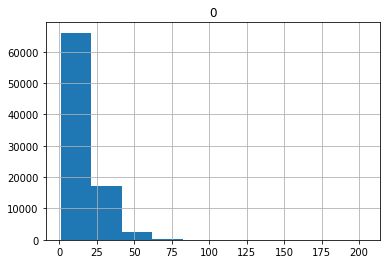

In [ ]:
num_seq = [len([s for s in re.split(SENTENCE_SPLITERS, d) if s != '']) for d in train_val_df['TEXT']]
seq_len = [len(s.split(" ")) for d in train_val_df['TEXT'] for s in re.split(SENTENCE_SPLITERS, d) if s != '']
num_char = [len(s.replace(" ", "")) for d in train_val_df['TEXT'] for s in re.split(SENTENCE_SPLITERS, d) if s != '']

pd.DataFrame(seq_len).hist()

In [ ]:
train_val_df['text_size'] = train_val_df['TEXT'].apply(lambda x: len([s for s in re.split(SENTENCE_SPLITERS, x) if s != '']))
train_val_df = train_val_df[train_val_df['text_size'] < 250]

### Model and Training functions/classes

In [ ]:
def process_data(data_df):
  documents, word_count, labels = [], {}, []
  label_encoder = LabelEncoder()
  label_encoder.fit(data_df['Metric'].tolist())

  for _, row in data_df.iterrows():
    document = []

    for s in re.split(SENTENCE_SPLITERS, row['TEXT']):
      if s != '':
        text = clean_str(s)
        if text:
          document.append(text)
          
        for word in text:
          if word not in word_count:
            word_count[word] = 0
          
          word_count[word] += 1
    documents.append(document)
    labels.append(row['Metric'])

  return {'documents': documents, 'word_counts': word_count}, {'labels': labels, 'label_encoder': label_encoder}

In [ ]:
class DocumentClassif(nn.Module):
  def __init__(self, embeddings, hidden_dim, dropout=0.2):
    super(DocumentClassif, self).__init__()
    self.hidden_dim = hidden_dim
    self.TEXT = embeddings
    self.text_embedding = nn.Embedding(self.TEXT.vocab.vectors.shape[0], self.TEXT.vocab.vectors.shape[1]).from_pretrained(TEXT.vocab.vectors)

    self.dropout = nn.Dropout(p=dropout)
    self.word_rnn = nn.GRU(self.TEXT.vocab.vectors.shape[1], hidden_dim // 2, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout)
    self.word_linear = nn.Linear(hidden_dim, hidden_dim)
    self.word_context = nn.Parameter(torch.rand(hidden_dim, 1, requires_grad=True))

    self.sentence_rnn = nn.GRU(hidden_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
    self.sentence_linear = nn.Linear(hidden_dim, hidden_dim)
    self.sentence_context = nn.Parameter(torch.rand(hidden_dim, 1, requires_grad=True))
    self.linear_class = nn.Linear(hidden_dim, 2)

  def forward(self, input):
    text_tokens = self._embed_text(input)
    input = self.text_embedding(text_tokens)
    B, NS, SL, H = input.shape # B x NS x SL x H
    input = torch.reshape(input, (-1, SL, H))# (B * NS) x SL x H
    input = self.dropout(input) 
    embed_word, _ = self.word_rnn(input) # (B  * NS) x SL x H
    embed_word = torch.reshape(embed_word, (B, NS, SL, -1)) # B x NS x SL x H
    context_embed = torch.tanh(self.word_linear(embed_word)) # B x NS x SL x H

    context_embed = F.softmax(torch.matmul(context_embed, self.word_context) / self.hidden_dim ** 0.5, dim=2)  # B x NS x SL x 1
    context_embed = context_embed.expand_as(embed_word) # B x NS x SL x H
    embed_sentence = (context_embed * embed_word).sum(axis=2) # B x NS x H

    embed_sentence = self.dropout(embed_sentence) # B x NS x H
    embed_sentence, _ = self.sentence_rnn(embed_sentence) # B x NS x H
    context_embed = torch.tanh(self.sentence_linear(embed_sentence)) # B x NS x H
    
    context_embed = F.softmax(torch.matmul(context_embed, self.sentence_context) / self.hidden_dim ** 0.5, dim=1)  # B x NS x 1
    context_embed = context_embed.expand_as(embed_sentence) # B x NS x H
    doc_embed = (context_embed * embed_sentence).sum(axis=1) # B x H
    final = self.linear_class(doc_embed)
    return final # B x 2

  def predict(self, input):
    text_tokens = self._embed_text(input)
    input = self.text_embedding(text_tokens)
    B, NS, SL, H = input.shape # B x NS x SL x H
    input = torch.reshape(input, (-1, SL, H))# (B * NS) x SL x H
    input = self.dropout(input) 
    embed_word, _ = self.word_rnn(input) # (B  * NS) x SL x H
    embed_word = torch.reshape(embed_word, (B, NS, SL, -1)) # B x NS x SL x H
    context_embed = torch.tanh(self.word_linear(embed_word)) # B x NS x SL x H

    word_attention = F.softmax(torch.matmul(context_embed, self.word_context) / self.hidden_dim ** 0.5, dim=2)  # B x NS x SL x 1
    context_embed = word_attention.expand_as(embed_word) # B x NS x SL x H
    embed_sentence = (context_embed * embed_word).sum(axis=2) # B x NS x H

    embed_sentence = self.dropout(embed_sentence) # B x NS x H
    embed_sentence, _ = self.sentence_rnn(embed_sentence) # B x NS x H
    context_embed = torch.tanh(self.sentence_linear(embed_sentence)) # B x NS x H
    
    sentence_attention = F.softmax(torch.matmul(context_embed, self.sentence_context) / self.hidden_dim ** 0.5, dim=1)  # B x NS x 1
    context_embed = sentence_attention.expand_as(embed_sentence) # B x NS x H
    doc_embed = (context_embed * embed_sentence).sum(axis=1) # B x H
    final = self.linear_class(doc_embed)
    return F.softmax(final, dim=1), word_attention,  sentence_attention 

  def _embed_text(self, X):
    device = self.word_context.device
    ndocuments = len(X)
    nseq = max(len(s) for s in X)
    nword = max(len(w) for s in X for w in s)

    sentences, positions = self._flat_text(X)
    processed_sentences = TEXT.process(sentences, device=device)

    embed = torch.ones(ndocuments, nseq, nword, dtype=torch.long, device=device)
    for emd, pos in zip(processed_sentences, positions):
      embed[pos[0], pos[1], : ] =  emd
    
    return embed

  def _flat_text(self, documents):
    sentences, positions = [], []
    for d, doc in enumerate(documents):
      for s, sent in enumerate(doc):
        sentences.append(sent)
        positions.append((d, s))

    return sentences, positions

In [ ]:
class FutureSocietyDataset(Dataset):
  def __init__(self, documents, labels):
    self.text = documents
    self.label = labels

  def collate(self, samples):
    data, labels = map(list, zip(*samples))
    return data, torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, idx):
    return self.text[idx], self.label[idx]

In [ ]:
def embedd_text(text, device):
  return torch.tensor([WORD_VECTORS[word] if word in VOCAB else WORD_VECTORS['unk'] for word in text], device=DEVICE)

def train_epoch(model, opt, dataloader, loss_fn, device):
  losses, preds, grounds = [], [], []
  model = model.train()
  for X, Y in dataloader:
    Y = Y.to(device)
    opt.zero_grad()
    output = model(X)

    loss = loss_fn(output, Y)
    loss.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    opt.step()
    losses.append(loss.item())
  
    preds.extend(np.argmax(F.softmax(output, dim=-1).detach().cpu(), 1).tolist())
    grounds.extend(Y.detach().cpu().tolist())

  return {'f1':  f1_score(grounds, preds),
          'loss': np.mean(losses),
          'acc': balanced_accuracy_score(grounds, preds),
          'precision': precision_score(grounds, preds),
          'recall': recall_score(grounds, preds)}

def eval_epoch(model, dataloader, loss_fn, device):
  losses, preds, preds_prob, grounds = [], [], [], []
  model = model.eval()
  with torch.no_grad():
    for X, Y in dataloader:
      Y = Y.to(device)

      output = model(X)

      loss = loss_fn(output, Y)
      losses.append(loss.item())

      preds_prob.extend(F.softmax(output, dim=-1).detach().cpu()[:,1].tolist())
      preds.extend(np.argmax(F.softmax(output, dim=-1).detach().cpu(), 1).tolist())
      grounds.extend(Y.detach().cpu().tolist())

  return {'f1':  f1_score(grounds, preds),
          'auc': roc_auc_score(grounds, preds_prob),
          'loss': np.mean(losses),
          'acc': balanced_accuracy_score(grounds, preds),
          'precision': precision_score(grounds, preds),
          'recall': recall_score(grounds, preds)}

def compute_threshold(model, dataloader, device):
  precision_recall_curve
  preds_prob, grounds = [], []
  model = model.eval()
  with torch.no_grad():
    for X, Y in dataloader:
      Y = Y.to(device)

      output = model(X)

      preds_prob.extend(F.softmax(output, dim=-1).detach().cpu()[:,1].tolist())
      grounds.extend(Y.detach().cpu().tolist())

  precision, recall, thresholds = precision_recall_curve(grounds, preds_prob)
  return precision, recall, thresholds

Training parameters

In [ ]:
training_params = {
    'test_split': 0.2,
    'val_split': 0.3,
    'batch_size': 4,
    'input_dim': 64,
    'hidden_dim': 64,
    'dropout': 0.5,
    'learning_rate': 1e-4,
    'momentum': 0.9,
    'weight_decay': 1e-2,
    'epochs': 200
}
train_df, val_df = train_test_split(train_val_df, test_size=training_params['val_split'], random_state=RANDOM_SEED)

### Train the model

In [ ]:
train_documents, train_labels = process_data(train_df)
val_documents, val_labels = process_data(val_df)
test_documents, test_labels = process_data(test_df)


train_text = train_documents['documents']
val_text = val_documents['documents']
test_text = test_documents['documents']

train_sentences = [s for d in train_text for s in d]

train_label = train_labels['label_encoder'].transform(train_labels['labels'])
val_label = train_labels['label_encoder'].transform(val_labels['labels'])
test_label = train_labels['label_encoder'].transform(test_labels['labels'])

train_dataset = FutureSocietyDataset(train_text, train_label)
val_dataset = FutureSocietyDataset(val_text, val_label)
test_dataset = FutureSocietyDataset(test_text, test_label)

train_dataloader = DataLoader(train_dataset, batch_size=training_params['batch_size'], shuffle=True, collate_fn=train_dataset.collate)
val_dataloader = DataLoader(val_dataset, batch_size=training_params['batch_size'], shuffle=True, collate_fn=val_dataset.collate)
test_dataloader = DataLoader(test_dataset, batch_size=training_params['batch_size'], shuffle=False, collate_fn=test_dataset.collate)
print("Train size {}, Val size {}, Test size {}".format(len(train_df), len(val_df), len(test_df)))
print("Train % true {}, Val % true {}, Test % true {}".format(train_label.sum() / len(train_label), val_label.sum() / len(val_label), test_label.sum() / len(test_label)))

Train size 693, Val size 298, Test size 255
Train % true 0.6320346320346321, Val % true 0.5536912751677853, Test % true 0.6313725490196078


#### Load/create embedding model

In [ ]:
word2vec_model = Word2Vec(sentences=train_sentences, size=training_params['input_dim'], window=5, min_count=5, workers=4, seed=RANDOM_SEED)
word2vec_model.train(train_sentences, total_examples=2, epochs=100) # I think the constructor also trains the model
word2vec_model.wv.save_word2vec_format(os.path.join(MODELPATH, f'word2vectors_{METRIC}.k2v'))

In [ ]:
# word2vec_vector = torchtext.vocab.GloVe(name="6B",dim=200)
word2vec_vector = Vectors(name=f'word2vectors_{METRIC}.k2v', cache=MODELPATH)

TEXT = torchtext.legacy.data.Field(batch_first=True) 
TEXT.build_vocab(train_sentences, min_freq=5)
TEXT.vocab.set_vectors(word2vec_vector.stoi, word2vec_vector.vectors, word2vec_vector.dim)

#### Initiate model and train

In [ ]:
model = DocumentClassif(TEXT, training_params['hidden_dim'], training_params['dropout'])
model = model.to(device=DEVICE)
optimizer = optim.Adam(model.parameters(), training_params['learning_rate'])#, momentum=training_params['momentum'], weight_decay=training_params['weight_decay'])
scheduler = optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5)
loss_fn = nn.CrossEntropyLoss().to(device=DEVICE)

In [ ]:
train_losses, val_losses = [], []
train_scores, val_scores, test_scores = [], [], []

best_score = None
early_stop = False
delta = 1e-3
patience = 20
counter = 0
finetune_embed = 1000

pbar = trange(training_params['epochs'])
for i in pbar:
  train_result = train_epoch(model, optimizer, train_dataloader, loss_fn, DEVICE)
  train_losses.append(train_result['loss'])
  train_scores.append(train_result['f1'])


  val_result = eval_epoch(model, val_dataloader, loss_fn, DEVICE)
  val_losses.append(val_result['loss'])
  val_scores.append(val_result['f1'])

  test_result = eval_epoch(model, test_dataloader, loss_fn, DEVICE)
  test_scores.append(test_result['f1'])

  scheduler.step()

  if i == finetune_embed:
    model.text_embedding.weight.requires_grad = True

  if best_score is None:
      best_score = val_result['loss']
  elif val_result['loss'] > best_score - delta:
      counter += 1
      if counter >= patience:
          early_stop = True
  else:
      best_score = val_result['loss']
      data = {
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'loss': loss_fn,
          'training_params': training_params,
          'train_loss': train_losses,
          'val_loss': val_losses,
          'train_f1': train_scores,
          'val_f1': val_scores,
          'test_f1': test_scores,
      }
      torch.save(data, os.path.join(MODELPATH, f'han_model_{METRIC}.pkl'))
      counter = 0

  if early_stop:
    break


  pbar.set_postfix(train_loss=train_result['loss'], train_f1=train_result['f1'], val_f1=val_result['f1'], counter=counter)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame({'Train Loss': train_losses, 'Val Loss': val_losses}).plot()

In [ ]:
print(f"Train f1: {data['train_f1'][-1]}, Val f1: {data['val_f1'][-1]},Test f1 {data['test_f1'][-1]}")

### Evaluate results

#### Load word embeddings and model weights

In [ ]:
# word2vec_vector = torchtext.vocab.GloVe(name="6B",dim=200)
word2vec_vector = Vectors(name=f'word2vectors_{METRIC}.k2v', cache=MODELPATH)
data= torch.load(os.path.join(MODELPATH, f'han_model_{METRIC}.pkl'))

#### Load dataset

In [ ]:
train_documents, train_labels = process_data(train_df)
val_documents, val_labels = process_data(val_df)
test_documents, test_labels = process_data(test_df)

train_text = train_documents['documents']
val_text = val_documents['documents']
test_text = test_documents['documents']

train_sentences = [s for d in train_text for s in d]

train_label = train_labels['label_encoder'].transform(train_labels['labels'])
val_label = train_labels['label_encoder'].transform(val_labels['labels'])
test_label = train_labels['label_encoder'].transform(test_labels['labels'])

train_dataset = FutureSocietyDataset(train_text, train_label)
val_dataset = FutureSocietyDataset(val_text, val_label)
test_dataset = FutureSocietyDataset(test_text, test_label)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=train_dataset.collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=val_dataset.collate)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_dataset.collate)

print("Train size {}, Val size {}, Test size {}".format(len(train_df), len(val_df), len(test_df)))
print("Train % true {}, Val % true {}, Test % true {}".format(train_label.sum() / len(train_label), val_label.sum() / len(val_label), test_label.sum() / len(test_label)))

#### Load dataset

In [ ]:
train_documents, train_labels = process_data(train_df)
val_documents, val_labels = process_data(val_df)
test_documents, test_labels = process_data(test_df)

train_text = train_documents['documents']
val_text = val_documents['documents']
test_text = test_documents['documents']

train_sentences = [s for d in train_text for s in d]

train_label = train_labels['label_encoder'].transform(train_labels['labels'])
val_label = train_labels['label_encoder'].transform(val_labels['labels'])
test_label = train_labels['label_encoder'].transform(test_labels['labels'])

train_dataset = FutureSocietyDataset(train_text, train_label)
val_dataset = FutureSocietyDataset(val_text, val_label)
test_dataset = FutureSocietyDataset(test_text, test_label)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=train_dataset.collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=val_dataset.collate)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_dataset.collate)

print("Train size {}, Val size {}, Test size {}".format(len(train_df), len(val_df), len(test_df)))
print("Train % true {}, Val % true {}, Test % true {}".format(train_label.sum() / len(train_label), val_label.sum() / len(val_label), test_label.sum() / len(test_label)))

#### Build model

In [ ]:
TEXT = torchtext.data.Field(batch_first=True) 
TEXT.build_vocab(train_sentences, min_freq=5)
TEXT.vocab.set_vectors(word2vec_vector.stoi, word2vec_vector.vectors, word2vec_vector.dim)

In [ ]:
loss_fn = data['loss']
model = DocumentClassif(TEXT, data['training_params']['hidden_dim'], data['training_params']['dropout'])
model.load_state_dict(data['model_state_dict'])
model = model.to(DEVICE)

#### Evaluate Model

In [ ]:
precision, recall, thresholds = compute_threshold(model, train_dataloader, DEVICE)
plt.plot(recall, precision)

In [ ]:
train_result = eval_epoch(model, train_dataloader, loss_fn, DEVICE)
val_result = eval_epoch(model, val_dataloader, loss_fn, DEVICE)
test_result = eval_epoch(model, test_dataloader, loss_fn, DEVICE)

print(f"Accuracy  -> Train: {train_result['acc']:.{3}}, Val: {val_result['acc']:.{3}}, Test: {test_result['acc']:.{3}}")
print(f"F1        -> Train: {train_result['f1']:.{3}}, Val: {val_result['f1']:.{3}}, Test: {test_result['f1']:.{3}}")
print(f"Precision -> Train: {train_result['precision']:.{3}}, Val: {val_result['precision']:.{3}}, Test: {test_result['precision']:.{3}}")
print(f"Recall    -> Train: {train_result['recall']:.{3}}, Val: {val_result['recall']:.{3}}, Test: {test_result['recall']:.{3}}")
print(f"AUC       -> Train: {train_result['auc']:.{3}}, Val: {val_result['auc']:.{3}}, Test: {test_result['auc']:.{3}}")

In [ ]:
preds, words, sentences, texts = [], [], [], []
results = []
model = model.eval()
with torch.no_grad():
  for i, (X, Y) in enumerate(tqdm(test_dataloader)):
    pred, word_attention, sentence_attention = model.predict(X)

    results.append({
        'pred': np.argmax(pred.detach().cpu().numpy(), 1)[0],
        'pred_prob': pred.detach().cpu().numpy()[0,1],
        'true': Y.detach().cpu().numpy()[0],
        'word_att': word_attention.detach().cpu().numpy(),
        'sent_att': sentence_attention.detach().cpu().numpy(),
        'text': X[0],
        'link': test_df.iloc[i]['Answer Link']
    })

In [ ]:
pred = [r['pred'] for r in results]
true = [r['true'] for r in results]
prob = [r['pred_prob'] for r in results]
print(f"Dataset {METRIC}:")
print(classification_report(true, pred))

In [ ]:
final_df = pd.DataFrame({'True': true, 'Pred': pred, 'Pred_prob':prob})
final_df.to_csv(os.path.join("./", f"{METRIC}_test_preds.csv"))

final_df = test_df.copy()
final_df['Prob'] = prob
final_df.to_csv(os.path.join("./", f"{METRIC}_test_preditions.csv"))

#### Print Results

In [ ]:
def create_html(result):
  template = '<span class="barcode"; style="font-size:14px; color: black; background-color: {}">{}</span>'
  blue_cmap=matplotlib.cm.Blues
  red_cmap=matplotlib.cm.Reds
  final = ""

  pred_label = bool(result['pred'])
  true_label = bool(result['true'])
  pred_color = 'green' if pred_label == true_label else 'red'

  final += '<p style="font-size:16px"> <span>Pred label: </span><span style="color:{};">{}</span></p>'.format(pred_color, pred_label)
  final += '<p style="font-size:16px"> <span>Answer Link: </span><a href="{}">{}</a></p>'.format(result['link'], result['link'])

  sentence_attention = normalize(np.reshape(result['sent_att'], (1, -1)))
  for sent, sent_att, word_attention in zip(result['text'], sentence_attention.squeeze(), result['word_att'].squeeze()):
    color = matplotlib.colors.rgb2hex(red_cmap(sent_att)[:3])
    word_attention = normalize(np.reshape(word_attention, (1, -1)))
    final += "<p>"
    final += template.format(color, '&nbsp' + " " + '&nbsp')
    for word, word_att in zip(sent, word_attention.squeeze()):
      color = matplotlib.colors.rgb2hex(blue_cmap(word_att * 0.8)[:3])
      final += template.format(color, ' ' + word + ' ')
    final += "</p>"
  
  return final

def print_result(result):
  display(HTML(create_html(result)))

def result2pdf(result, pdf):
  weasyprint.HTML(string=create_html(result)).write_pdf(pdf)

In [ ]:
wrong_examples = [i for i, r in enumerate(results) if r['pred'] != r['true']]

In [ ]:
!rm  ./*.pdf

In [ ]:
result_test_folder = "./"
for i, idx in tqdm(enumerate(wrong_examples), total=len(wrong_examples)):
  file_path = os.path.join(result_test_folder, f"wrong_example_{i}.pdf")
  result2pdf(results[idx], file_path)

In [ ]:
final_path = os.path.join("./", f"{METRIC}_test_wrong_examples.pdf")
!pdfunite `ls -v $result_test_folder/*.pdf` $final_path

In [ ]:
print_result(results[7])

In [ ]:
wrong_examples[0]

## Results

Using six sentences as a threshold and having almost 75% of statements to classify, Hierarchical Attention Network showed worse performance than the Rule-Based and Random Forest approach. Hierarchical Attention Network yields around 69% accuracy, while the Rule-Based and Random Forest approach accounted for 73% accuracy.
 



#Transformer
 
### Introduction
 
We want to leverage the comment section of the data to train a classification model.
 
Reminder: On the original data, the labelisation has been made as follows:
 
People label each statement saying if the metric is present or not in the current statement
Sometimes, they justify their finding by copy-pasting part of the statement justifying their choice
We transform this original training data in order to build a custom training set using the information contained in the comment section. More precisely, we define as:
 
Positive labels - justification for the metric being present in the current statement: extract sentences of the statements present in the comment section as a citation.
negative labels: randomly sample sentences present in the statements and not present in the comment section
Then, we train a BERT Transformer model to classify sentences that can justify the metric being present (positive label) or not (negative label).
 
To predict the presence or not of the metric within a global statement, we simply use this model to predict if each sentence of the statement is a justification or not. If we find at least one sentence being predicted as a justification, then we say that the overall statement contains the metric.



### Install Requirements

In [ ]:
#!pip install tensorflow
#!pip install transformers

In [ ]:
# import core libraries 
import pandas as pd
import numpy as np
from pathlib import Path

# import deeplearning libraries
import transformers
import tensorflow as tf



### Data Cleaning

In [ ]:
# parameters
METRIC = "assessment"

In [ ]:
# Load statements and comments
# The load_comments function clean up comments, by selecting only sentences in statements used as justification in comments
df = load_dataset_from_gdrive(METRIC)
comments = load_comments_from_gdrive(METRIC)
df["comments"] = df.TEXT.apply(lambda x: comments[x] if x in comments else [])
# Shuffle data and split in train_test
shuffled_df = df.sample(frac=1, random_state=60)
train, test = shuffled_df[:int(0.8*len(shuffled_df))], shuffled_df[int(0.8*len(shuffled_df)):]

Possible values : ['conducting research' 'in development' 'no' 'risk-based questionnaires'
 'unknown' 'use of risk management tool or software']


Delete observations with metric but without any comment

In [ ]:
def filtre(x):    
    return not (x["Metric"]==True and len(x["comments"])==0)

train_not_filtered = train.copy()
train = train[train.apply(lambda x: filtre(x), axis=1)]

Since the final model will use full sentences as input data, we enlarge text extracted from comment section, by finding the whole sentence associated. These sentences are the positive labels. For the negative labels, we use all the other sentences.

In [ ]:
def get_full_sentence(text, sub_text, start, end):
    pre = True
    while pre:
        start -= 1
        new_char = text[start]
        if new_char not in [".", "\n"]:
            sub_text = new_char + sub_text
        else:
            pre = False
            
    post = True
    while post:
        end += 1
        new_char = text[end]
        if new_char not in [".", "\n"]:
            sub_text += new_char
        else:
            post = False
            
    return sub_text + ".", start, end

In [ ]:
train_positive_samples = []
train_negative_samples = []
for idx, row in train.iterrows():
    full_comment = []
    old_end = 0
    sub_negative_samples = []
    for comment in row.comments:
        text, start, end = get_full_sentence(row.TEXT, comment["text"], comment["start"], comment["end"])
        full_comment.append(text)
        sub_negative_samples.append(row.TEXT[old_end: start])
        old_end = end
        
    train_negative_samples.append(sub_negative_samples)
    train_positive_samples.append(full_comment)

Cut string as sentences using "\n" and "." as separators. Eliminate sentences with less than 40 characters.

In [ ]:
train_negative_samples = "".join([sub.replace("\n", ".") for l in train_negative_samples for sub in l]).split(".")
train_negative_samples = [i for i in train_negative_samples if len(i) > 40]

train_positive_samples = "".join([sub.replace("\n", ".") for l in train_positive_samples for sub in l]).split(".")
train_positive_samples = [i for i in train_positive_samples if len(i) > 40]

Create list of sentences with corresponding labels (justification or not).

In [ ]:
train_targets = list(np.ones(len(train_positive_samples)).astype(int)) + list(np.zeros(len(train_negative_samples)).astype(int))
train_comments = train_positive_samples + train_negative_samples

### Training

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encode sentences with numerical values.

In [ ]:
def process_comments(tokenizer, comments, max_length):
    input_ids, attention_mask = [], []
    for comment in comments:
        proccessed_comment = tokenizer.encode_plus(comment, max_length=max_length, pad_to_max_length=True)
        input_ids.append(proccessed_comment["input_ids"])
        attention_mask.append(proccessed_comment["attention_mask"])
    return input_ids, attention_mask

In [ ]:
MAX_LENGTH = 128

train_input_ids, train_mask = process_comments(tokenizer, train_comments, MAX_LENGTH)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": train_input_ids, "attention_mask": train_mask}, train_targets))

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = len(train_input_ids)

# Shuffle data during training and use batch size of 32
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compile model.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Train model.

In [ ]:
model.fit(train_dataset, epochs=2, validation_steps=10)

Epoch 1/2
 89/251 [=========>....................] - ETA: 1:58:45 - loss: 0.2558 - accuracy: 0.9133

KeyboardInterrupt: ignored

### Prediction

In [ ]:
# Prediction
def predict_doc(text, model, threshold=.5):
    '''
    Function used to predict if a statement contains the metric
    Parameters:
        text: string, Statement to predict
        model: transformers.models, Transformer classification model
        theshold: float, Probability above which we consider a sentence being a justification for the metric
    Return:
        bool, prediction, if the metric is present or not within the statement
        list, list of sentences justifying the prediction (presence of the metric within the statement)
    '''
    list_sentences = [i for i in text.replace("\n", ".").split(".") if len(i) > 40]
    input_ids, mask = process_comments(tokenizer, list_sentences, MAX_LENGTH)
    predictions = model.predict({"input_ids": np.array(input_ids), "attention_mask": np.array(mask)})
    probas = softmax(predictions[0], axis=1)
    idx = np.where(probas[:,1] > threshold)[0]
    return sum(probas[:,1] > threshold) / len(probas) > 0, [list_sentences[i] for i in idx]

In [ ]:
prediction, justifications = predict_doc(statement, model)

## Results
Even though the transformers-based approach enhances the model explainability by giving the sentence which may explain the prediction, overall, this system fell behind compared to the rules-based and random forest approach and the HAN  approach. This method has 66% of accuracy. Nevertheless, Transformers has been applied as an unsupervised learning method (i.e. it is not using labels), so there is still room for improvements to lift the classifier’s performance as a supervised or semi-supervised problem.

